Removed page 7 with simmilarity 99.25353652263375%


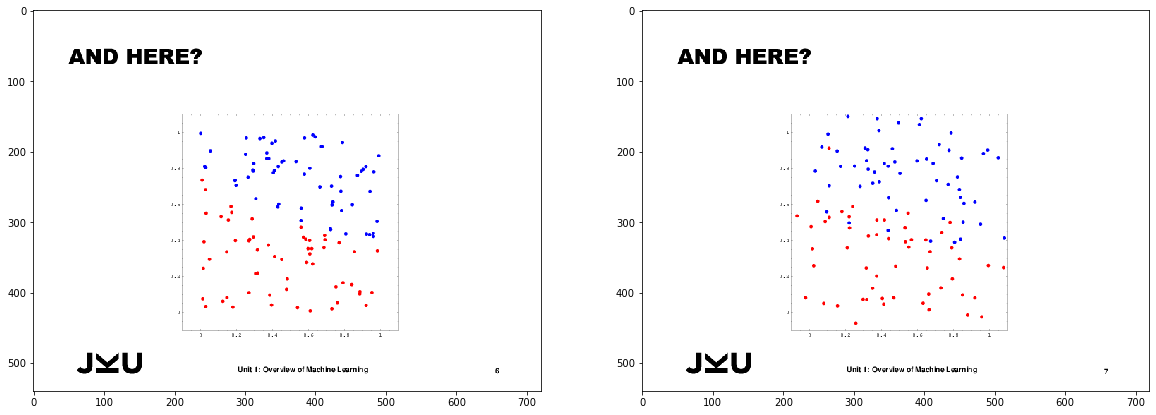

Removed page 8 with simmilarity 99.25990226337449%


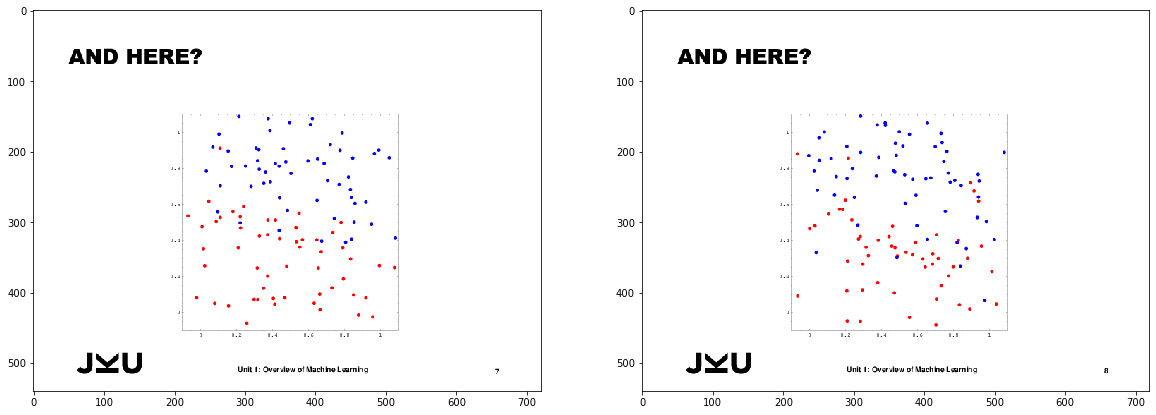

Removed page 9 with simmilarity 99.26684670781893%


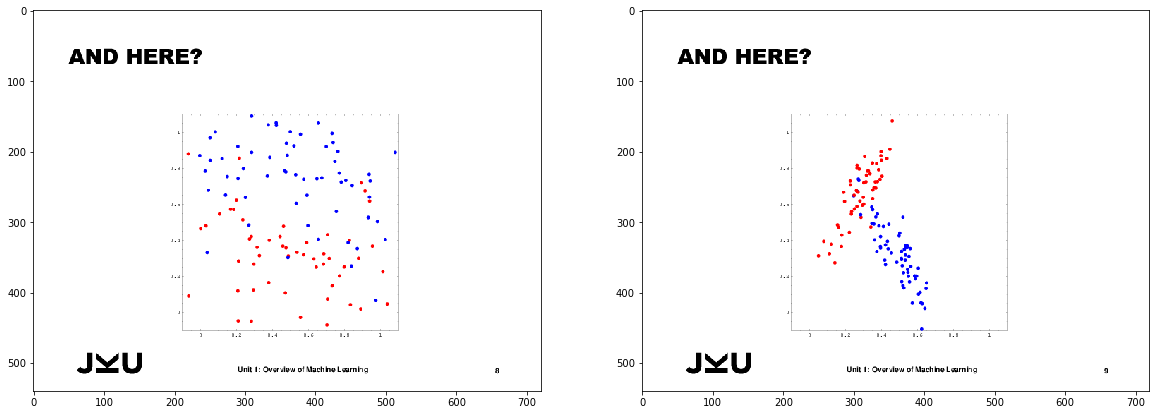

Removed page 10 with simmilarity 99.24929269547324%


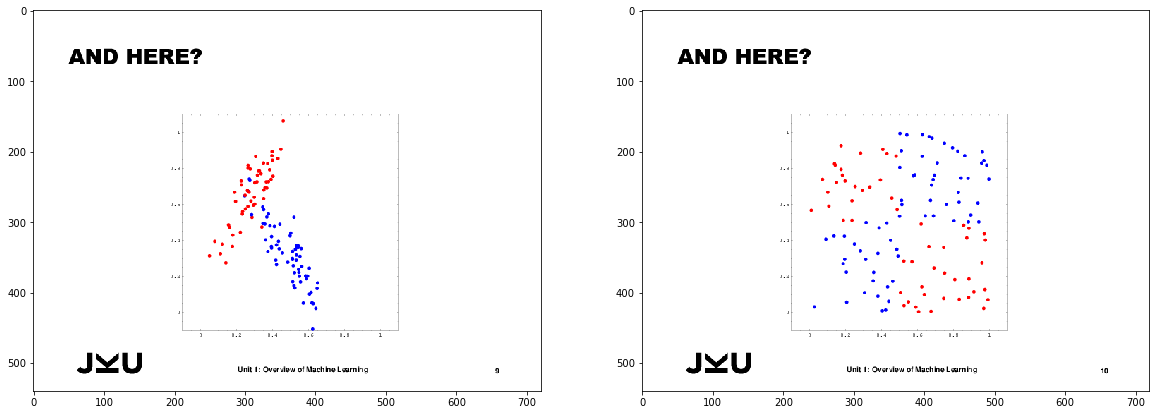

Removed page 26 with simmilarity 99.13175154320987%


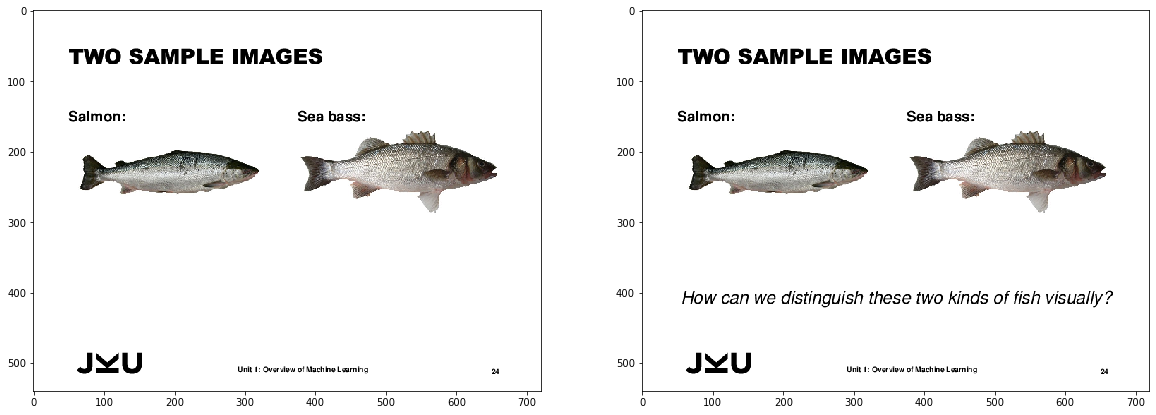

Removed page 35 with simmilarity 99.05844907407408%


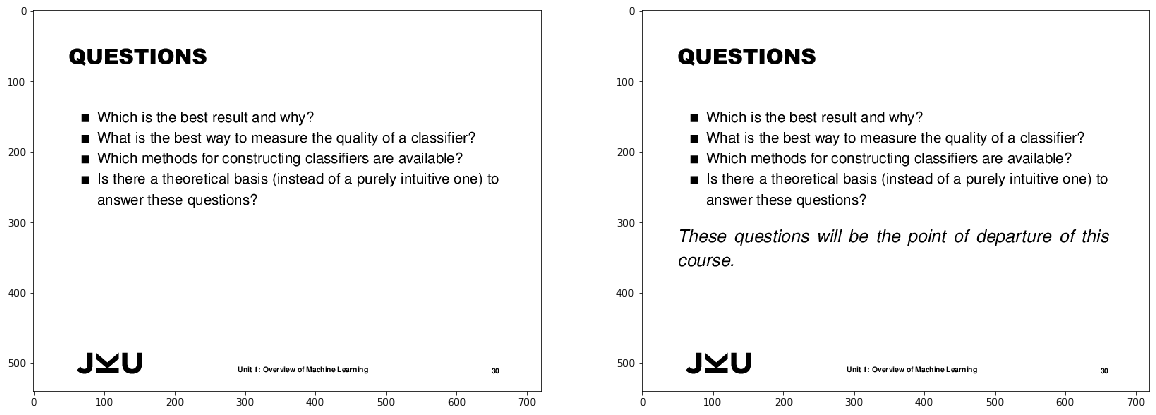

In [37]:
import os
import io
import numpy as np
from wand.image import Image
from wand.display import display
from PyPDF2 import PdfFileReader, PdfFileWriter
import matplotlib.pyplot as plt

%matplotlib inline

EQ_THRESHOLD = 0.99

def pdf_page_to_png(page, resolution = 72):
    """
    Returns specified PDF page as wand.image.Image png. src: https://gist.github.com/jrsmith3/9947838
    :param PyPDF2.PdfFileReader src_pdf: PDF from which to take pages.
    :param int pagenum: Page number to take.
    :param int resolution: Resolution for resulting png in DPI.
    """
    dst_pdf = PdfFileWriter()
    dst_pdf.addPage(page)

    pdf_bytes = io.BytesIO()
    dst_pdf.write(pdf_bytes)
    pdf_bytes.seek(0)
    # if you get an PolicyError: edit out <policy domain="delegate" rights="none" pattern="gs" /> in /etc/ImageMagick-7/policy.xml
    return Image(file = pdf_bytes, resolution = resolution)

def pdf_page_to_np(page, resolution = 72):
    # https://stackoverflow.com/questions/47599012/how-to-convert-a-wand-image-object-to-numpy-array-without-opencv?rq=1
    image = pdf_page_to_png(page)
    image.format = 'gray' #If rgb image, change this to 'rgb' to get raw values
    image.alpha_channel = False
    image = np.array(image)
    image = image.reshape(image.shape[1], image.shape[0], image.shape[2])
    return image

def similarity(last, curr):
    """ check if 2 pdf-pages are similar enough
    by converting pages to images and check how many rgb-channels match """
    eq = np.equal(pdf_page_to_np(curr), pdf_page_to_np(last))
    # return ratio
    return np.sum(eq) / np.prod(eq.shape)

def rem_dup(in_fn, out_fn=None):
    if out_fn == None:
        path, ext = os.path.splitext(in_fn)
        out_fn = path + ".dedup"+ext
    # read original
    orig = PdfFileReader(in_fn, strict=False)
    
    # create new pdf with only non-duplicated pages
    pdf_writer = PdfFileWriter()
    pdf_writer.addPage(orig.getPage(0))
    for page in range(orig.getNumPages()-1):
        last = orig.getPage(page)
        curr = orig.getPage(page+1)
        simmi = similarity(last, curr)
        if simmi < EQ_THRESHOLD:
            pdf_writer.addPage(curr)
        else:
            print(f"Removed page {page+2} with simmilarity {simmi*100}%")
            _, splt = plt.subplots(1,2, figsize=(20,20))
            splt[0].imshow(pdf_page_to_np(last))
            splt[1].imshow(pdf_page_to_np(curr))
            plt.show()
    # write output
    with open(out_fn, 'wb') as out:
        pdf_writer.write(out)

if __name__ == '__main__':
    rem_dup("ml.pdf")